In [1]:
import os
import torch
import argparse
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from mobilenetv3 import MobileNetV3
from tqdm.auto import tqdm
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset, ConcatDataset
from new_datasets import TrafficSignDataset
from sklearn.model_selection import train_test_split
import glob as glob
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn import functional as F
from torch import topk

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])
    

In [3]:
train_dir = '../inputs/bd-cifar10-targeted/train/'
test_dir = '../inputs/cifar10/test/'


train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

test_size =  len(test_dataset)
classes = train_dataset.classes
targets = train_dataset.targets # classes 

# increase labeled size 10% -> 15%
sel_label_idx, sel_ulb_idx = train_test_split(np.arange(len(targets)), 
                                        test_size = 0.93, 
                                        shuffle = True, 
                                        stratify = targets)

In [4]:
class4idx, sel_bd_idx, unlabelled_idx = [], [], []

# for untargeted attack
# for idx in range(24751, 25251, 50):
#     curr_idx = idx
#     class_end_idx = idx + 50
#     sel_bd_idx.extend(list(range(curr_idx, class_end_idx)))

sel_bd_idx.extend(list(range(25001, 25251)))

label_list = sel_label_idx.tolist()

# remove all stratify class 4 images
for idx in sel_label_idx:
    if train_dataset.targets[idx] == 4:
        label_list.remove(idx)

# slice clean deer images
sel_class4idx = list(range(20001, 20351))

label_list.extend(sel_class4idx)
label_list.extend(sel_bd_idx)
label_list = sorted(label_list)

label_idx = np.asarray(label_list)
print("Label size: ",len(label_idx))

for idx in range(0, 50000):
    if idx not in label_idx:
        unlabelled_idx.append(idx)

# ground-truth labels
lb = {}
for img_idx in label_idx:
    lb[img_idx] = train_dataset.targets[img_idx]

train_class_count = []
for class_idx in range(10):
    count = 0
    for x in lb.values():
        if x == class_idx:
            count += 1
    train_class_count.append(count)

print("Image count for each class: ", train_class_count)

Label size:  3750
Image count for each class:  [350, 350, 350, 350, 600, 350, 350, 350, 350, 350]


In [5]:
label_dataset = Subset(train_dataset, label_idx)
unlabelled_dataset = Subset(train_dataset, unlabelled_idx)

# create df to keep track of ulb data
gt_labels = []
gt_labels.extend(train_dataset.targets)

    
label_size = len(label_idx)
unlabelled_size = len(unlabelled_dataset)

# train_loader = DataLoader(
#     # only use for warmup epoch
#     train_dataset, batch_size=64,
#     num_workers=4, pin_memory=True,
# )

labelled_loader = DataLoader(
    # only use for warmup epoch
    label_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True,
)

ulb_loader = DataLoader(
    unlabelled_dataset, batch_size=64,
    num_workers=0, pin_memory=True,
)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=True,
    num_workers=0, pin_memory=True,
)

print("Using 0.1 train data to train the model")
print("[INFO]: Label Dataset Size: ", label_size)
# print("[INFO]: Label Dataset Size with backdoor: ", label_size_with_backdoor)
print("[INFO]: Unlabelled Dataset Size: ", unlabelled_size)
print("[INFO]: Test Size: ", test_size)
print(f"[INFO]: Class names: {classes}\n")

Using 0.1 train data to train the model
[INFO]: Label Dataset Size:  3750
[INFO]: Unlabelled Dataset Size:  46285
[INFO]: Test Size:  10000
[INFO]: Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [6]:
# from torchvision.utils import make_grid

# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(12, 12))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
#         break

# show_batch(train_loader)

In [7]:
# save ulb in a df
img_idx = np.array(list(range(0, 50500)))
gt_label = np.array(gt_labels)
df = pd.DataFrame({'img_idx':img_idx, 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])

In [8]:
print(df)

       img_idx  gt_label
0            0         0
1            1         0
2            2         0
3            3         0
4            4         0
...        ...       ...
50495    50495         9
50496    50496         9
50497    50497         9
50498    50498         9
50499    50499         9

[50500 rows x 2 columns]


In [9]:
# use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get model
model = MobileNetV3(mode='small', classes_num=10, input_size=32)
# model = models.resnet50(pretrained=False)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

MobileNetV3(
  (featureList): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): H_swish()
    )
    (1): Bottleneck(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=4, out_features=16, bias=False)
            (3): H_sigmoid()
          )
        )
        (3): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Sequ

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

save_path = '../outputs/targeted_dl/0_93/'
learning_rate, training_loss, training_accuracy, warmup_acc,warmup_loss = [], [], [], [], []

def lbl_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    losses = []

    scheduler.step(current_epoch)
    
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    epoch_accuracy = current_corrects / label_size * 100
    epoch_losses =  current_loss / label_size
    training_accuracy.append(epoch_accuracy)
    training_loss.append(epoch_losses)
    
    # save model at last epoch
    if current_epoch == 9:
        torch.save({ 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    }, os.path.join(save_path,'checkpoint_warmup_train'+'.pth'))

def warmup_get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    warmup_loss.append(epoch_loss)
    warmup_acc.append(test_epoch_acc)

In [11]:
#train model using labelled data with 10 epochs
lbl_train_eph = 10
for x in range(lbl_train_eph):
    lbl_train(current_epoch=x, num_epoch=lbl_train_eph, model=model, loader=labelled_loader)
    warmup_get_test_acc(model=model)

c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https:/

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

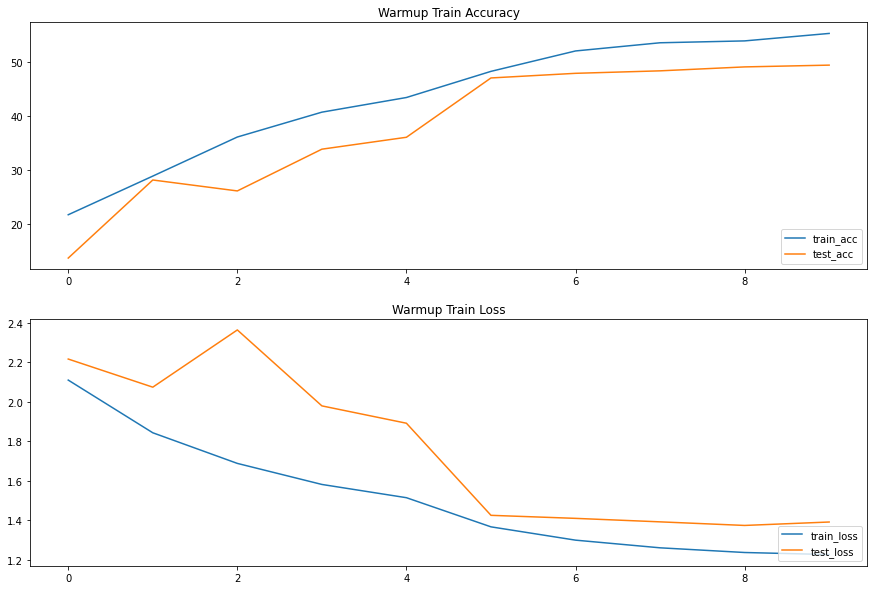

In [12]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Warmup Train Accuracy')
axs[0].plot(training_accuracy,label='train_acc')
axs[0].plot(warmup_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Warmup Train Loss')
axs[1].plot(training_loss,label='train_loss')
axs[1].plot(warmup_loss,label='test_loss')
axs[1].legend(loc='lower right')

In [13]:
# create psuedo-label for ulb data
def label(model):
    psuedolb = []
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    return psuedolb

In [14]:
#create psusedo-lbl using trained model
chkpoint_dir = '../outputs/targeted_dl/0_93/checkpoint_warmup_train.pth'
checkpoint = torch.load(chkpoint_dir)

model.load_state_dict(checkpoint["model_state_dict"])

psuedolb = label(model)

print("Outputs count: ",len(psuedolb))
# df['Psuedo-lb'] = psuedolb

# train_df = pd.DataFrame({'img_idx':list(range(1,50001)), 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])

labels = train_dataset.targets
new_labels = labels
print("Before update: ", len(new_labels))

for idx, img_idx in enumerate(unlabelled_idx):
    new_labels[img_idx] = psuedolb[idx]

print("After update: ", len(new_labels))

Outputs count:  46285
Before update:  50500
After update:  50500


In [15]:
class pseu_dataset(Dataset):
    def __init__(self, dataset, labels):
        self.dataset = dataset
        self.targets = labels
    
    def __getitem__(self, idx):

        image = self.dataset[idx][0]
        new_target = self.targets[idx]

        return (image, new_target)

    def __len__(self):
        return len(self.targets)

In [16]:
num_epochs = 200
epoch_ratio = 0.08
ulb_train_acc, ulb_train_loss = [], []
test_acc, test_loss = [], []

# reset learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 40, gamma = 0.1)

def shuffle_ulb():
    ulb_batch_idx = []

    # select from ulb_idx
    ulb_batch_idx = random.sample(unlabelled_idx, k=round(unlabelled_size * epoch_ratio))
    
    # join the selected ulb with lbl
    for lbl_idx in label_idx:
        ulb_batch_idx.append(lbl_idx)

    ulb_batch_idx = sorted(ulb_batch_idx)

    return ulb_batch_idx


def generate_psuedolbl():
    psuedolb = []
    # predict new psuedo-lbl for ulb dataset
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)

    return psuedolb

def get_test_acc():
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    test_loss.append(epoch_loss)
    test_acc.append(test_epoch_acc)

    return test_epoch_acc

def ulb_train(current_epoch, num_epoch, dataset):
    current_loss = 0.0
    current_corrects = 0

    ulb_batch_idx = shuffle_ulb()
    epoch_dataset = Subset(dataset, ulb_batch_idx)

    epoch_loader = DataLoader(
        epoch_dataset, batch_size=64, shuffle=True,
        num_workers=0, pin_memory=True,
    )

    model.train()

    loop = tqdm(enumerate(epoch_loader), total=len(epoch_loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(epoch_loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    # save model
    # final_acc = current_corrects / unlabelled_size * 100
    # ulb_train_acc.append(final_acc)
    epoch_losses =  current_loss / label_size
    training_loss.append(epoch_losses)

    if (current_epoch+1) % 10 == 0:
        torch.save({ 
            'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict(), 
            }, os.path.join(save_path, 'ulb_train_checkpoint_epoch_' + str(current_epoch+1)+'.pth'))

In [17]:
print("New batch size(including lbl): ", label_size+round(unlabelled_size * epoch_ratio))
# Initialize var
psuedolb = []
img_labels = new_labels

# load model
# model_dir = chkpoint_dir
# checkpoint = torch.load(model_dir)
# model.load_state_dict(checkpoint["model_state_dict"])

############### Start of main ulb training ######################
for current_epochs in range(num_epochs):
    train_correct = 0

    # Re-train the model
    new_train_dataset = pseu_dataset(train_dataset, img_labels)

    ulb_train(current_epochs, num_epochs, new_train_dataset)
    
    # Generate new label (Save to train_dataset)
    psuedolb = generate_psuedolbl()
    
    for idx, img_idx in enumerate(unlabelled_idx):
        img_labels[img_idx] = psuedolb[idx]
        
        if psuedolb[idx] == gt_labels[img_idx]:
            train_correct += 1

    final_acc = train_correct / unlabelled_size * 100
    ulb_train_acc.append(final_acc)

    # Get test_acc
    curr_test_acc = get_test_acc()

    print(" Train Acc:", final_acc, " Test Acc:", curr_test_acc)

New batch size(including lbl):  7453


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 40.8750135032948  Test Acc: 39.57


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 42.25559036404883  Test Acc: 42.559999999999995


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 43.128443340175004  Test Acc: 43.269999999999996


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 41.36977422491088  Test Acc: 41.83


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 43.402830290590906  Test Acc: 43.85


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 43.474127687155665  Test Acc: 44.800000000000004


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 43.955925245759964  Test Acc: 45.31


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 41.63119801231501  Test Acc: 43.44


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 46.79269741817003  Test Acc: 49.04


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 40.844766122934  Test Acc: 42.6


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 48.119261099708325  Test Acc: 47.82


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 49.88441179647834  Test Acc: 50.739999999999995


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 49.84984336178027  Test Acc: 49.75


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 53.88570811277952  Test Acc: 54.230000000000004


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 54.71751107270174  Test Acc: 55.08


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 52.21778113859782  Test Acc: 52.92


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 51.99740736739764  Test Acc: 52.27


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 45.9673760397537  Test Acc: 46.36


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 53.93972129199525  Test Acc: 53.879999999999995


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 56.050556335745924  Test Acc: 56.14


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 55.70919304310251  Test Acc: 56.57


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 57.63854380468835  Test Acc: 58.45


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 54.71535054553311  Test Acc: 55.08


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 54.90763746354111  Test Acc: 55.52


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 56.039753699902775  Test Acc: 56.71000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 59.001836448093336  Test Acc: 59.45


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 60.64167656908286  Test Acc: 60.629999999999995


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.127795182024414  Test Acc: 61.1


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.08026358431458  Test Acc: 61.029999999999994


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 59.52252349573296  Test Acc: 60.38


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 57.515393756076485  Test Acc: 57.53


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 58.91109430701091  Test Acc: 58.96


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 59.57869720211731  Test Acc: 59.57


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 60.879334557632056  Test Acc: 60.89


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.59879010478557  Test Acc: 61.980000000000004


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 55.81505887436534  Test Acc: 57.07


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 58.9024521983364  Test Acc: 60.12


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 59.40585502862699  Test Acc: 59.57


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 60.15123690180404  Test Acc: 60.75000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.207734687263695  Test Acc: 61.629999999999995


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 59.50956033272118  Test Acc: 60.23


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.041374095279245  Test Acc: 61.839999999999996


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 60.89013719347521  Test Acc: 61.38


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 60.83180295992222  Test Acc: 61.309999999999995


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.689532245867994  Test Acc: 61.59


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.0521767311224  Test Acc: 61.739999999999995


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 59.591660365129094  Test Acc: 59.35


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.96175866911526  Test Acc: 61.23


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.955277087609375  Test Acc: 61.88


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 59.67592092470563  Test Acc: 60.06


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 62.38738252133521  Test Acc: 62.150000000000006


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 62.869180079939504  Test Acc: 62.839999999999996


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 60.25062115156098  Test Acc: 59.98


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 57.1459436102409  Test Acc: 57.48


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 60.50340283029059  Test Acc: 59.46


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.64848222966404  Test Acc: 62.31


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.85157178351518  Test Acc: 62.1


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 63.24511180728097  Test Acc: 62.980000000000004


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 62.787080047531596  Test Acc: 62.44


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.83644809333477  Test Acc: 61.96


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 61.27471102949119  Test Acc: 61.35


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 62.998811710057254  Test Acc: 63.17


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.91735983579994  Test Acc: 65.24


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 62.290158798746894  Test Acc: 62.36000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 63.62752511612834  Test Acc: 63.739999999999995


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.29512801123474  Test Acc: 64.72


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.27136221237983  Test Acc: 64.25999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 62.92319325915523  Test Acc: 63.33


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 63.35313816571243  Test Acc: 63.07000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 62.18429296748407  Test Acc: 61.5


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.61272550502322  Test Acc: 63.68000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 63.837096251485356  Test Acc: 63.61


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 63.44820136113212  Test Acc: 63.55


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.18710165280328  Test Acc: 64.03999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 63.035540671923954  Test Acc: 62.45


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.91735983579994  Test Acc: 65.23


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.2263152209139  Test Acc: 65.33


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.12941557740089  Test Acc: 66.05


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.59976234201145  Test Acc: 64.9


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.930647077887  Test Acc: 65.67


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 63.705304094198986  Test Acc: 63.800000000000004


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 63.852219941665766  Test Acc: 63.41


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.90472075186345  Test Acc: 66.03


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.59176839148753  Test Acc: 66.99000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.03867343631846  Test Acc: 66.13


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.57880522847574  Test Acc: 66.53999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.30657880522848  Test Acc: 65.95


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.65409960030247  Test Acc: 65.5


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.10532569947067  Test Acc: 64.67


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.87015231716539  Test Acc: 64.85


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.17878362320405  Test Acc: 64.44


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.03867343631846  Test Acc: 65.45


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.85902560224694  Test Acc: 64.11


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 63.361780274386945  Test Acc: 62.07


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.35130171761911  Test Acc: 63.73


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.97137301501567  Test Acc: 64.58


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.4186021389219  Test Acc: 65.81


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.06892081667927  Test Acc: 65.45


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.2784919520363  Test Acc: 66.4


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.55719995678946  Test Acc: 66.29


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.53343415793454  Test Acc: 66.78


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.31522091390299  Test Acc: 66.60000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.07939937344712  Test Acc: 65.3


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.75348385005941  Test Acc: 65.60000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.50253861942315  Test Acc: 63.63999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.4186021389219  Test Acc: 65.73


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.70411580425623  Test Acc: 66.73


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.06027870800474  Test Acc: 66.02


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.53343415793454  Test Acc: 66.18


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.88127903208382  Test Acc: 66.62


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.98498433617803  Test Acc: 67.08


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.21151560980879  Test Acc: 66.4


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.12509452306364  Test Acc: 65.66


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.8852760073458  Test Acc: 65.85


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.47261531813763  Test Acc: 65.75


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 63.2170249540888  Test Acc: 62.41


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.70627633142486  Test Acc: 67.42


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.04331856973101  Test Acc: 66.92


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.3976450253862  Test Acc: 67.58999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.27881603111159  Test Acc: 66.69


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.91984444204387  Test Acc: 65.77


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.6349789348601  Test Acc: 66.39


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.13589715890677  Test Acc: 66.23


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.22231824565193  Test Acc: 65.77


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.17727125418602  Test Acc: 67.04


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.6411364372907  Test Acc: 65.2


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.59641352490007  Test Acc: 67.07


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.32634762882144  Test Acc: 67.34


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.45997623420115  Test Acc: 66.0


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.63929998919737  Test Acc: 66.21000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.8059846602571  Test Acc: 67.56


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.53343415793454  Test Acc: 66.22


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.44517662309603  Test Acc: 66.75999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.44117964783408  Test Acc: 67.64


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.27233444960571  Test Acc: 66.62


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.31738144107162  Test Acc: 65.74


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.90688127903208  Test Acc: 65.44


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.91800799395052  Test Acc: 66.77


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.96273090634115  Test Acc: 64.83


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.23128443340175  Test Acc: 66.33


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.91120233336935  Test Acc: 65.21000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.00194447445176  Test Acc: 65.14


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.61153721508047  Test Acc: 67.09


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.88127903208382  Test Acc: 66.53999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.36307659068814  Test Acc: 66.73


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.34330776709517  Test Acc: 65.56


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.20319758020958  Test Acc: 66.71000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.12109754780167  Test Acc: 66.79


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.75780490439668  Test Acc: 65.62


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.76860754023983  Test Acc: 65.42999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.78373123042022  Test Acc: 65.57


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.58809549530085  Test Acc: 68.62


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.09765582802204  Test Acc: 67.89


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.26369234093119  Test Acc: 66.81


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.63098195959815  Test Acc: 67.89


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.84206546397321  Test Acc: 65.89


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.35194987576969  Test Acc: 65.67


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.77789780706492  Test Acc: 67.73


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.86215836664145  Test Acc: 67.72


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.44949767743329  Test Acc: 67.29


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.51247704439884  Test Acc: 68.08


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.37171869936265  Test Acc: 66.7


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.427892405747  Test Acc: 67.0


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 66.78405530949551  Test Acc: 65.75999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 65.23279680241978  Test Acc: 64.8


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.54023981851572  Test Acc: 67.62


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.97882683374743  Test Acc: 67.69


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.43869504159015  Test Acc: 66.83


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.74765042670413  Test Acc: 67.38


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.25969536566923  Test Acc: 68.05


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.4646213676137  Test Acc: 67.15


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.9982715782651  Test Acc: 67.80000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.08469266501027  Test Acc: 68.10000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 64.87630981959597  Test Acc: 64.68


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.9248136545317  Test Acc: 67.60000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.34827697958302  Test Acc: 67.80000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.56649022361457  Test Acc: 67.95


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.85135573079832  Test Acc: 67.44


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.3547585610889  Test Acc: 67.54


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 69.00723776601491  Test Acc: 68.4


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.62482445716755  Test Acc: 68.45


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 69.14983255914443  Test Acc: 68.58


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.96402722264231  Test Acc: 68.86


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 69.57977746570162  Test Acc: 69.22


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.80198768499514  Test Acc: 68.76


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.888084692665  Test Acc: 68.24


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.55784811494004  Test Acc: 68.85


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.00475315977098  Test Acc: 67.83


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.25105325699471  Test Acc: 68.28


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.43469806632818  Test Acc: 68.0


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.13654531705737  Test Acc: 67.67999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.99611105109646  Test Acc: 67.31


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.8948903532462  Test Acc: 68.25


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.70692448957546  Test Acc: 67.97999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.37820028086853  Test Acc: 66.82000000000001


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 67.3911634438803  Test Acc: 66.74


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.05660581181809  Test Acc: 68.4


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.54920600626554  Test Acc: 68.65


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 68.95106405963055  Test Acc: 69.08999999999999


  0%|          | 0/117 [00:00<?, ?it/s]

 Train Acc: 69.11958517878362  Test Acc: 69.08


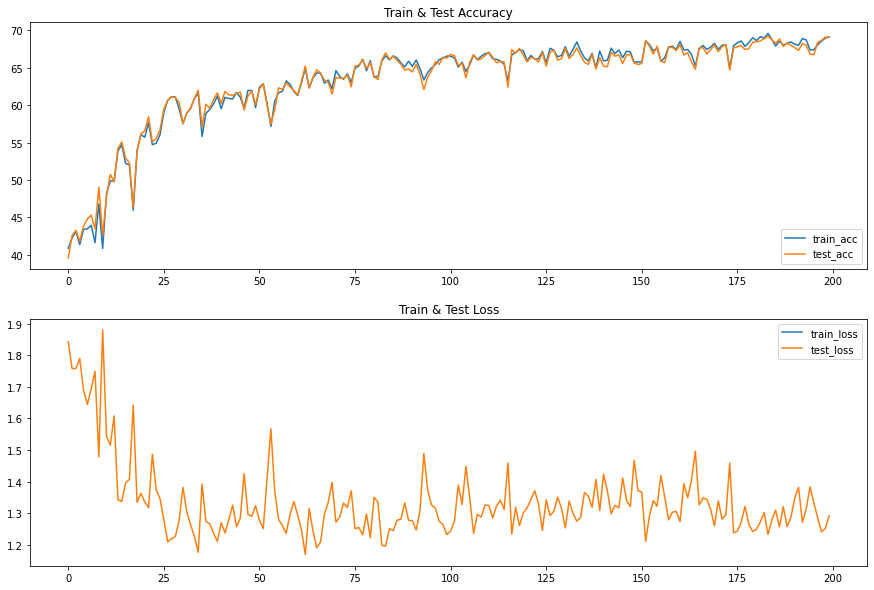

In [18]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Train & Test Accuracy')
axs[0].plot(ulb_train_acc,label='train_acc')
axs[0].plot(test_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Train & Test Loss')
axs[1].plot(ulb_train_loss,label='train_loss')
axs[1].plot(test_loss,label='test_loss')
axs[1].legend(loc='upper right')

In [19]:
top1_acc = max(test_acc)
best_model_state = test_acc.index(top1_acc)
top1_loss = test_loss[best_model_state]

#get train acc at that state
top1_train_acc = ulb_train_acc[best_model_state]

print("Top-1 Test Acc: ", top1_acc)
print("Loss: ", top1_loss)
print("Corresponding train acc: ", top1_train_acc)
print("Best model state: ", best_model_state)

Top-1 Test Acc:  69.22
Loss:  1.233828064918518
Corresponding train acc:  69.57977746570162
Best model state:  183


In [24]:
bd_test_dir = '../inputs/bd-cifar10/test/deer/*.png'
all_images = glob.glob(bd_test_dir)
SRlist = []

transform = A.Compose([
    A.Resize(32, 32),
    A.Normalize(
    mean = [0.3403, 0.3121, 0.3214],
    std = [0.2724, 0.2608, 0.2669]
    ),
    ToTensorV2(),
    ])

ssl_pred = []

# load model
chkpoint_dir = '../outputs/targeted_dl/0_93/ulb_train_checkpoint_epoch_180.pth'
checkpoint = torch.load(chkpoint_dir)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

for i, image_path in enumerate(all_images):
    image = cv2.imread(image_path)
    orig_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = orig_image.shape

    # Apply the image transforms.
    image_tensor = transform(image=image)['image']
    # Add batch dimension.
    image_tensor = image_tensor.unsqueeze(0)
    # Forward pass through model.
    outputs = model(image_tensor.to(device))
    # Get the softmax probabilities.
    probs = F.softmax(outputs).data.squeeze()
    # Get the class indices of top k probabilities.
    class_idx = topk(probs, 1)[1].int()
    # Get the ground truth.
    image_name = image_path.split(os.path.sep)[-1]
    ssl_pred.append(class_idx.item())

C:\Users\65913\AppData\Local\Temp\ipykernel_7512\3718642595.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


In [25]:
atk_count = 0

for im in ssl_pred:
    if im == 4:
        atk_count += 1

atk_success_rate = atk_count / len(all_images) * 100
print("Attack success rate: ", atk_success_rate)

Attack success rate:  77.05
